In [1]:
from moseq2_detectron_extract.io.session import Session
from sklearn.cluster import MiniBatchKMeans
from moseq2_detectron_extract.io.proc import apply_roi
import tqdm
import cv2
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt


In [2]:
from moseq2_detectron_extract.model.util import select_frames_kmeans
session = Session("E:\moseq_raw_data\Yue_mice\session_20200805115013\depth.dat")
ids = select_frames_kmeans(session, 100)

Getting background...


Finding plane:  47%|█████████████████████████████▍                                | 474/1000 [00:00<00:00, 4735.96it/s]

Getting roi...


Processing batches:   0%|                                                                       | 0/36 [00:00<?, ?it/s]

Detected true depth: 685.0


c:\users\josh\anaconda3\envs\moseq-detectron2\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Processing batches: 100%|██████████████████████████████████████████████████████████████| 36/36 [03:37<00:00,  6.03s/it]


Kmeans clustering ... (this might take a while)


In [5]:
ids

[16530,
 35544,
 34155,
 35765,
 34942,
 24573,
 4194,
 35599,
 4891,
 32527,
 869,
 31051,
 21860,
 2222,
 15286,
 4790,
 27501,
 8238,
 35158,
 27003,
 16519,
 5575,
 33420,
 35867,
 10612,
 15507,
 3524,
 303,
 15136,
 12140,
 14568,
 23983,
 20862,
 12842,
 16648,
 8121,
 4085,
 4710,
 27265,
 25236,
 12473,
 8915,
 17039,
 23222,
 16903,
 33613,
 12676,
 29121,
 32139,
 12632,
 23646,
 25901,
 32588,
 9531,
 3470,
 3851,
 29258,
 9073,
 12050,
 27442,
 4901,
 3382,
 15493,
 22516,
 18024,
 5594,
 23864,
 30432,
 12201,
 8929,
 19871,
 10847,
 33669,
 30165,
 17807,
 27331,
 19314,
 18364,
 30937,
 6980,
 27300,
 10784,
 32275,
 19146,
 13156,
 7885,
 26516,
 26932,
 11798,
 28338,
 19639,
 15924,
 25355,
 2013,
 6653,
 17482,
 4306,
 21316,
 24260,
 5314]

In [6]:
for f in tqdm.tqdm(session.index(list(ids))):
    print(f[1].shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.41it/s]

(100, 424, 512)


In [ ]:
session = Session("E:\moseq_raw_data\Yue_mice\session_20200805115013\depth.dat")
bground_im, roi, true_depth = session.find_roi()
min_height = 5
max_height = 100

In [31]:
nframes = 1000
chunk_size = 10
scale = 2

downsampled = np.zeros((nframes, int(roi.shape[0] / scale), int(roi.shape[1] / scale)))
for b, (frame_idxs, raw_frames) in enumerate(tqdm.tqdm(session.sample(nframes, chunk_size), desc='Processing batches', leave=True)):
    #tqdm.tqdm.write(str(frame_idxs))
    raw_frames = bground_im - raw_frames
    raw_frames[raw_frames < min_height] = 0
    raw_frames[raw_frames > max_height] = max_height
    raw_frames = apply_roi(raw_frames, roi)
    raw_frames = raw_frames
    
    for i, frame in enumerate(tqdm.tqdm(raw_frames, desc='Resizing Frames', leave=False, disable=True)):
        idx = (b * chunk_size) + i
        downsampled[idx, :, :] = resize(frame, downsampled.shape[1:], anti_aliasing=True, preserve_range=True)
    


Processing batches: 100%|████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]


In [35]:
print("Kmeans clustering ... (this might take a while)")
data = downsampled - downsampled.mean(axis=0)
data = data.reshape(data.shape[0], -1)  # stacking

numframes2pick = 50
kmeans_batchsize = 100
kmeans_max_iter = 50
kmeans = MiniBatchKMeans(
    n_clusters=numframes2pick, tol=1e-3, batch_size=kmeans_batchsize, max_iter=kmeans_max_iter
)
kmeans.fit(data)

Kmeans clustering ... (this might take a while)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=50, max_no_improvement=10, n_clusters=50,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.001,
        verbose=0)

In [36]:
kmeans.

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=50, max_no_improvement=10, n_clusters=50,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.001,
        verbose=0)

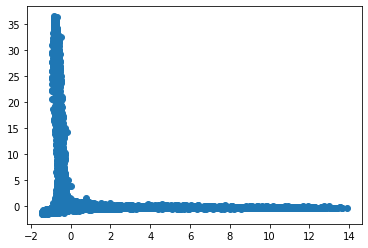

In [41]:
plt.scatter(x=kmeans.cluster_centers_[0,:], y=kmeans.cluster_centers_[1,:])

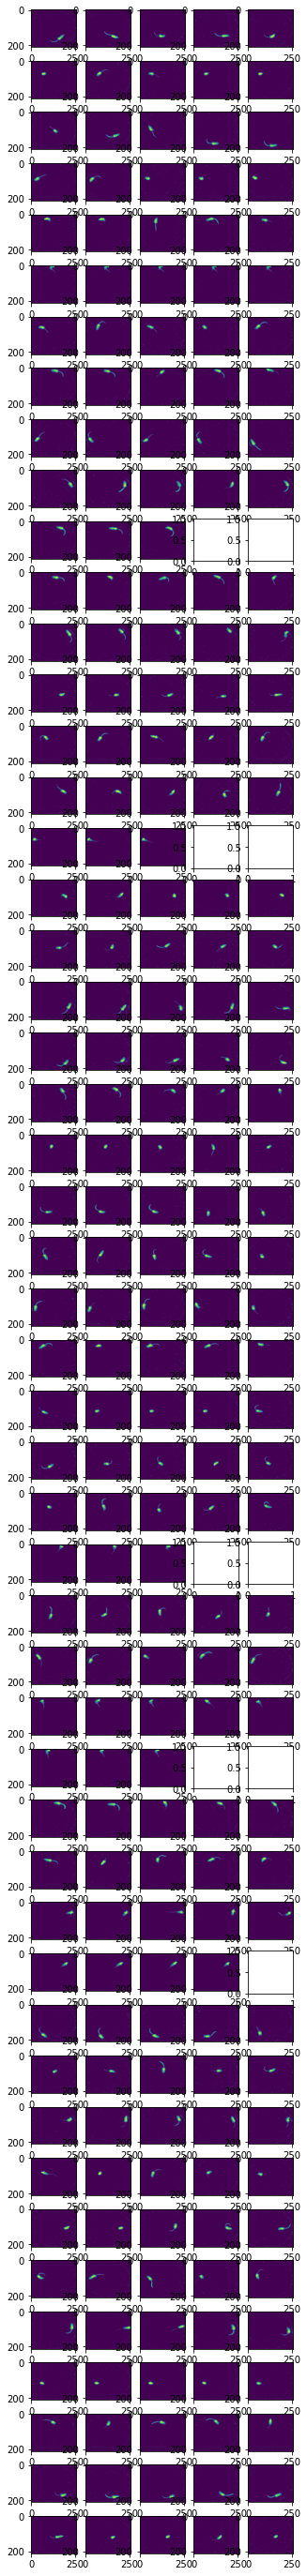

In [45]:
fig, axs = plt.subplots(numframes2pick, 5, figsize=(5, 50))
for clusterid in range(numframes2pick):  # pick one frame per cluster
    clusterids = np.where(clusterid == kmeans.labels_)[0]

    numimagesofcluster = len(clusterids)
    if numimagesofcluster > 0:
        for i in range(numimagesofcluster):
            if i < 5:
                axs[clusterid, i].imshow(downsampled[clusterids[i]])